> Copyright©2022 ZJU EAI


## **基于 LeNet-5 的 MNIST 手写数字识别**
  1998年，LeCun等人提出了基于卷积（Convolution）的神经网络模型(论文链接 http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) 。在本次实验中，您需要实现LeNet-5网络模型实现MNIST数据集手写数字识别，并且至少达到95%以上的正确率。

  通常的RGB图片，由R（红）G（绿）B（蓝）三个通道组成，对于一张大小为 H x W 的图片，数据存储可由下方的示意图表示：
  
  ![channel](https://miro.medium.com/max/1050/1*icINeO4H7UKe3NlU1fXqlA.jpeg)

  整张图片由三个[height, width]大小的矩阵组成，矩阵里的每个元素代表一个像素点，像素点的取值为整数的$[0,255]$或者浮点数的$[0,1]$，整张图片可以表示为一个三维的张量$[H,W,C]$，其中H代表长度，W代表宽度，C代表通道数（Channel）。

  下面介绍MNIST数据集，MNIST是一个学习深度学习常用的数据集，他由一张张28x28大小的**单通道**灰度图像组成。一张手写数字图片可以表示为一个形状为$[28,28,]$的张量。



如果您的本地存储空间以及算力不够充足，可以使用Google Colab进行实验，相同的ipynb文件在如下地址：
https://drive.google.com/file/d/1IpX3cjJJa-Ctetyz3cejIj1rS8e_7yZg/view?usp=sharing 请复制后自行修改。

1. **导入模块**

    在这里我们导入`Pytorch`用来进行开发。您应当首先对Pytorch的张量（Tesnor）类有所了解，并掌握张量之间运算的方法（API与Numpy比较相似）。

    下面简单介绍一下一些重要的组件：

     *   [torch.nn](https://pytorch.org/docs/stable/nn.html): 用于搭建网络的基本组件
     *   [torch.utils.data](https://pytorch.org/docs/stable/data.html): 提供了Dataset和Dataloader两个重要的类，用于创建数据集以及加载数据
     *   [torch.optim](https://pytorch.org/docs/stable/optim.html): 提供了常用的优化器（optimizer），例如SGD、Adam。您应当对Pytorch的计算图模型以及自动求梯度功能有所了解

    `torchvision`是pytorch项目的另一个模块，它包含一些常用的数据集（例如本实验使用的MNIST）、一些训练好的模型、图像处理工具等。

    如果有其他问题，可以查询Pytorch的官方文档(https://pytorch.org/docs/stable/index.html)。

In [ ]:
# import pytorch module
import torch
import torch.nn as nn

# submodules regarding data
from torch.utils.data import Dataset, DataLoader

import torchvision

"""
Optional: tensorboard is a module developed by Google Tensorflow.
It offers convenient logging method to record the training process and visualization.
"""
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir='/log')


2. **超参数（Hyper-parameter）的设置**
   
    除了网络中需要通过梯度下降训练的权重等参数，还有一些参数并不直接参与训练，而是在训练开始前预先设定，因而被称为“超参数”。他们对训练过程的收敛性、收敛速度等有重要影响

    下面介绍一下常见的需要设定的超参数：

     *  `epoch`: 将训练集中的数据全部经过网络训练一次被称为一个epoch

     *  `batch size`: 批（batch）的大小。为了较好的利用GPU并行运算的能力，**mini-batch SGD**每次训练一个batch size大小的数据并且梯度下降一次，batch size过小，那么这一个batch不能很好地反应数据集整体的性质，优化效果差；如果batch size过大，显存的开销较大，而且一个epoch内梯度下降的次数会减少，使得收敛速度变慢。

     *  `learning rate`: optimizer的学习率，learning rate过大则收敛性比较差；过小则收敛速度比较慢。此外，部分optimizer还有自己独有的超参数可以设定，例如SGD with momentum、Adam。optimizer还可以设定weight decay用来正则化、schedule用来动态调整学习率。

In [ ]:
# Hyperparameters
train_batch_size = 4
valid_batch_size = 2
num_epochs = 10
learning_rate = 0.001

3. **定义网络结构**

    自定义的网络需要继承`nn.Module`类，并且实现前向传播的`forward`函数，优化时，pytorch会帮您完成求梯度的过程。

    以下是常见的网络层，可以在官方文档找到使用方法：

     *  **Convolution**: nn.Conv1d, nn.Conv2d

     *  **Pooling**: nn.AvgPool2d, nn.MaxPool2d

     *  **Non-linear activation function**: nn.Relu, nn.Sigmoid, nn.Tanh

     *  **Full connection**: nn.Linear

     *  **Dropout**: nn.Dropout
    
    下方实现了一个最简单的模型，它由一层全连接层构成，它将接受一个形状为$[B, 32, ]$的张量的输入，输出一个$[B, 2, ]$的张量作为特征输出，其中B代表batch size。特征输出经过进一步得到输入的向量从属于某个类别的概率，我们可以用来计算损失函数，或者进行预测。

    例如，我们要把向量分为两类，标为$0,1$，输入32位向量$[1,1,..,1]$，最后得到概率$[0.3,0.7]$，说明网络认为该向量有30%的概率属于类0，70%的概率属于类1。当然，这是一个非常简单的模型，分类的正确率不会很高。

    你需要根据LeCun的论文完成`LeNet-5`的网络定义（可以进行适当修改），完成`forward`函数。请注意，网络的输入是二维图片，形状为$[B, H, W, ]$，请特别注意张量经过网络层时形状的变化，否则会产生报错。

    

In [ ]:
# 网络架构的定义

class BoringModel(nn.Module):
  """
  Boring model as example.
  This model gets a input tensor of shape [batch_size, 32],
  and produce an output of shape [batch_size, 2]. You can assume that
  we classify the input tensor into 2 classes.

  Please implement LeNet-5 Model yourself to recognize the numbers.
  Keep in mind that you should pay attention to shape of tensors and
  handle it carefully.
  """
  def __init__(self):
    super(BoringModel, self).__init__()
    # define the layers of the net
    self.layer = nn.Linear(32, 2)
  
  # Do forward propagation and get output
  def forward(self, x):
    x = self.layer(x)
    return x

# Create a instance of our model.
model = BoringModel()
# Create a model and send its parameters to device.
# If you have GPUs and CUDA installed, they will on GPU memory.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# print(model)

4. **准备数据和数据加载器**

    方便起见，这里我们使用`torchvision`的MNIST数据集，它是Pytorch内部使用的Dataset类型，可以作为Dataloader的输入参数项。

    **需要注意的是**：你可能会遇到以下报错
    ```bash
    TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>
    ```
    这是因为，MNIST数据集内部仍然是图形格式，而模型不能直接把图片作为输入，你需要把图片转化为pytorch张量；同时，为了较好地学习到图像地特征，你需要对MNIST数据集进行归一化（Normalize）。这些变换都应当由下方代码的transform处给出，详细请参考`torchvision.transforms`对进行数据集进行处理。


    当你对数据集完成适当的处理，就可以创建dataloader，dataloader每次会返回一个batch的数据。在train时我们应当打乱数据的顺序，以提高训练效果，validation和test时没有必要打乱数据，这由参数shuffle控制。

    下面简单介绍以下几个数据集相关的概念:

     *  `train set`: 训练数据集，每次我们从中随机抽取batch size个图片组成一个batch进行前向传播，计算梯度做一次梯度下降优化。随着训练的进行，模型在训练集中的loss会逐渐下降。

     *  `validation set`: 验证数据集，用来监测训练过程，例如，当模型在训练集上loss下降，但在验证集上loss反而上升时，可能说明模型过拟合，应当提早结束训练。

     *  `test set`: 测试数据集，用来验证模型的泛化能力。

In [ ]:
# 准备 dataset 和 dataloder.

transform = None

train_set = torchvision.datasets.MNIST(root="/path/to/place/put/dataset", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)

valid_set = torchvision.datasets.MNIST(root="/path/to/place/put/dataset", train=False, download=True, transform=transform)
valid_loader = DataLoader(valid_set, batch_size=valid_batch_size, shuffle=False)

下面我们从dataloader中随机抽取几张图片并且展示，下面是可能的效果：

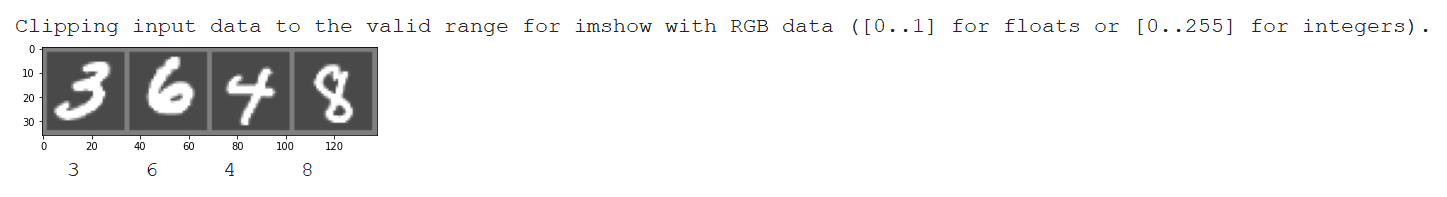

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    # do something to unnormalize the img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

5. **训练过程与验证过程**

    在这里我们选择每个epoch进行一次Validation

    您需要：

      *   选择合适的[损失函数](https://pytorch.org/docs/stable/nn.html#loss-functions)（loss function）以及[优化器](https://pytorch.org/docs/stable/optim.html)（optimizer），设定优化器可能的超参数。

      *   **训练模型**：前向传播，计算loss，反向传播得到梯度，优化器梯度下降更新参数一次，称为一次training step，下方代码已给出，你需要实现代码，把合适的变量输出，从而你能看到随着训练进行，模型在训练集的loss逐渐下降，说明模型逐渐学习到图片的特征。

      *   **验证模型**：前向传播，得到模型预测的结果，和正确的标签进行对比，计算并且输出模型预测的正确率。请实现代码，

In [ ]:
# 训练过程


# Dummy loss function
loss_fn = torch.sum
# Prepare optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs): 
    # Training process.
    model.train()
    for i, (batch, label) in enumerate(train_loader):
      # send the training batch to the device
      batch = batch.to(device)
      # forward propagation.
      output = model(batch) 
      
      # clear the grad in the last training step
      optimizer.zero_grad() 
      # calculate the loss.
      loss = loss_fn(output)

      # back propagation, get grad.
      loss.backward() 
      # update the weights once.
      optimizer.step() 

      # ============ 请在此实现您的代码 ===================
      # 请实现代码，输出 train 过程的 loss:
      # 您应当发现随着训练的进行，training loss 逐渐下降，并最后逐渐收敛
      # =================================================

    # Validation process.
    # .eval() will set some layers in validation state
    model.eval()
    correct = 0
    total = 0
    # torch.no_grad() would set model not do the gradient computing
    with torch.no_grad():
      for test_data, test_label in valid_loader:
        # ================= 请在此实现您的代码 ============================
        # 在此实现从验证集读取数据输入给模型，模型得到预测的分类结果，
        # 计算并且输出模型预测的正确率。
        # 您可以先提前猜测，随着训练进行，模型预测正确率（ACC）的变化情况。
        # ================================================================
    
    print("Epoch [{}/{}], Acc: {:.4f} %".format(epoch, num_epochs, 100 * correct / total))


# Close the tensorboard writer
# writer.flush()
# writer.close()